# Updated Pipeline for joining ERA/MODIS

In Notebook `02.Join_MODIS_with_ERA_NetCDF` we were finding for every ERA datapoint the single nearest MODIS datapoint, and then filtering by some tolerance. i.e. if the nearest MODIS datapoint is 1 bazillion miles away from the ERA point, we dont want to count that as a match. Exactly what this tolerance should be is open for discussion, but we set it at 50 km.



An alternate way to do this matching as shown in this notebook is to reverse this process and say:

* For every MODIS point, what is the nearest ERA datapoint?
* Filter by some tolerance
* Groupby for each ERA lat/long point


# Dictionaries, configs, imports

In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import sys
# import cartopy.crs as ccrs
# from scipy.interpolate import griddata
import geopandas as gpd
# #from geopandas import GeoDataFrame
# #from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors
# from datetime import timedelta, date


#These dictionaries describe the local hour of the satellite
local_times = {"aquaDay":"13:30",
               "terraDay":"10:30",
               "terraNight":"22:30",
               "aquaNight":"01:30"
              }
# and are used to load the correct file for dealing with the date-line.
min_hours = {"aquaDay":2,
            "terraDay":-1,
            "aquaNight":-1,
            "terraNight":11}
max_hours = {"aquaDay":24,
            "terraDay":22,
            "aquaNight":13,
            "terraNight":24}


#Path to MODIS data
satellite_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/'

#Path to ERA data
era_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw'




# Functions

In [2]:
def get_satellite_slice(date : str,
                        utc_hour : int,
                        satellite : str,
                        latitude_bound = None #Recommend only using |lat| < 70 degrees
                        ):
    
    """Function to load hourly slice of MODIS data from Mat Chantry.
       Some naming changes from original, logic mostly unchanged.
       We now drop coordinates that are filtered out"""
    
    #Due to crossing of the datetime, some times will be saved different date
    if utc_hour < min_hours[satellite]:
        file_date = str((np.datetime64(date) - np.timedelta64(1,'D')))
    elif utc_hour > max_hours[satellite]:
        file_date = str((np.datetime64(date) + np.timedelta64(1,'D')))
    else:
        file_date = date
        
    print(file_date)
    # Open .tif 
    #sat_xr = xr.open_rasterio(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif')
    sat_xr = xr.open_dataarray(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif',engine="rasterio")

    # Rename spatial dimensions
    sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})
    
    #Create time delta to change local to UTC
    time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 
    
    #Convert local satellite time to UTC and round to nearest hour
    time = (pd.to_datetime([file_date + " " + local_times[satellite]]*time_delta.shape[0]) - time_delta).round('H')
    
    #What date/time does the user want?
    target_time = np.datetime64(f'{date} {utc_hour:02}:00:00')
        
    #Is this target time in this data array?
    time_filter = np.expand_dims(time == target_time,axis=(0,1))
    
    # Make this 1d time filter a 2d mask
    mask = np.logical_and(np.isfinite(sat_xr),time_filter)
    
    # Also filter by latitude
    space_filter = np.expand_dims(np.abs(sat_xr.latitude) < latitude_bound,axis=(0,-1))
    
    #...and add this condition to the mask
    mask = np.logical_and(mask,space_filter)
    
    
    #Check we have some true values in our mask
    if mask.sum() == 0:
        print('There is no appropriate data')
        return 0
      
    #Apply mask to data array
    sat_xr_filtered= sat_xr.where(mask,drop=True).load() 
    
     
    #Close
    sat_xr.close()
    sat_xr = None
    
    
   
    return sat_xr_filtered[0,::-1,:]





def get_era_data(date : str,
                 utc_hour : str,
                 field : str,
                 bounds : dict,
                 source: str):

    """Function to load hourly slice of ERA data 
       Additional filtering by max/min longitude, read from matching MODIS file
    """
        
    #Load the data
    month = '_'.join(date.split('-')[:-1])
    
    if source == 'ERA_skin':
        name = '_skin_'
    if source == 'ERA_sfc':
        name = '_'
        
    utc_0hour = f'{utc_hour:02}'
    fname = f'{era_folder}/{source}/NetCDF/{date}T{utc_0hour}:00:00.000000000.nc'
    ds_era = xr.open_dataset(fname)
    
        
    #Grab correct field
    if field is not None:
        da = ds_era[field]
    else:
        da = ds_era
    
     # Also filter by latitude/longtiude
    longitude_filter = (da.longitude > bounds['longitude_min']) & (da.longitude < bounds['longitude_max'])
    latitude_filter =  (da.latitude > bounds['latitude_min']) & (da.latitude < bounds['latitude_max'])
    
  
    da_filtered = da.where(longitude_filter & latitude_filter,drop=True)

    #Explictley close the file
    ds_era.close()
    
    return da_filtered
    



    
def filter_out_sea(ds : xr.Dataset):
    
    """
    Use lsm variable to filter out ocean values, retaining only land values
    Returns a pandas dataframe
    """
    
    df = ds.to_dataframe().reset_index()
    df_land = df.loc[df['lsm'] > 0.5]
    
    
    return df_land
    
    
    

import faiss

def faiss_knn(database,query):
    
    """
    Use faiss library (https://github.com/facebookresearch/faiss) for fass k-nearest neighbours on GPU
    
    Note that the nearness is an L2 (squared) norm on the lat/long coordinates, rather than a haversine metric
    """
    
    #Database
    xb = database[["latitude", "longitude"]].to_numpy().astype('float32')
    xb = xb.copy(order='C') #C-contigious
    
    #Query
    xq = query[["latitude", "longitude"]].to_numpy().astype('float32') 
    xq = xq.copy(order='C')
    
    #Create index
    d = 2                            # dimension
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatL2(d) #index
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat) # make it into a gpu index
    gpu_index_flat.add(xb)  
    
    #Search
    k = 1                          # we want to see 1 nearest neighbors
    distances, indices = gpu_index_flat.search(xq, k)
    

    #Combine into a single df with all data
    df = query.reset_index().join(database.iloc[indices.flatten()].reset_index(), lsuffix='_MODIS',rsuffix='_ERA')
    df['L2_distance'] = distances
    df['MODIS_idx'] = indices
    df['H_distance'] = haver(df['latitude_MODIS'],df['longitude_MODIS'],df['latitude_ERA'],df['longitude_ERA']) #Haversine distance
    
    #Filter out any large distances
    tolerance = 50 #km
    df_filtered = df.query('H_distance < %.9f' % tolerance)
    


    #Group it. Each ERA point has a bunch of MODIS points. Group and average
    df_grouped = df_filtered.groupby(['latitude_ERA','longitude_ERA'],as_index=False).mean()

    


    
    
    return df_grouped


def haver(lat1_deg,lon1_deg,lat2_deg,lon2_deg):
    
    """
    Given coordinates of two points IN DEGREES calculate the haversine distance
    """
    
    #Convert degrees to radians
    lat1 = np.deg2rad(lat1_deg)
    lon1 = np.deg2rad(lon1_deg)
    lat2 = np.deg2rad(lat2_deg)
    lon2 = np.deg2rad(lon2_deg)


    #...and the calculation
    delta_lat = lat1 -lat2
    delta_lon = lon1 -lon2
    Re = 6371 #km
    Z = np.sin(delta_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2
    H = 2*Re*np.arcsin(np.sqrt(Z)) #Haversine distance in km
    return H

    
    
    
    

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
        
        
        

def plot_map(ds,x,y,q): #slow plotting function

    #Takes a ds, converts to pandas df
    
    if isinstance(ds, pd.DataFrame):
        df = ds
    else:
        df = ds.to_dataframe().reset_index()#.dropna()
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    plt.show()
    


In [3]:
#Set the parameters
date = '2018-04-19'
utc_hour = 11

# Getting all the data

Same methods as previous notebook:

In [4]:

#MODIS
MODIS = get_satellite_slice(date=date,utc_hour=utc_hour,satellite='aquaDay',latitude_bound=70)
MODIS_df = MODIS.to_dataframe(name='MODIS_LST').reset_index()

#ERA
delta = 1.0
bounds = {"latitude_min" :MODIS.latitude.data.min()-delta,
          "latitude_max" :MODIS.latitude.data.max()+delta,
          "longitude_min":MODIS.longitude.data.min()-delta,
          "longitude_max":MODIS.longitude.data.max()+delta
          }
fields = None #['t2m','v10'] #'None' selects all data variables. Selecting > 1 field returns a dataset rather than a data array
ERA_sfc = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_sfc')
ERA_skin = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_skin')
ERA = xr.merge([ERA_sfc, ERA_skin])
ERA_df_land = filter_out_sea(ERA)



2018-04-19


# Finding a match


By virtue of the time slices we have performed, the data is already matched in time.

We now need to match in space. i.e. for each gridpoint in ERA we want to find the closest match in MODIS. We use the Haversine distance as our closeness metric.

We also need to enforce a tolerance to filter out matches which are not sufficently close.

This process returns a pandas df of the ERA data joined with the matching rows in MODIS. This provides a corresponding MODIS temperature for each entry (where available) in ERA. We also return the Haversine distance between the matches. Perhaps this could be used as some kind of error... 

Example:

In [5]:
%%time
df = faiss_knn(ERA_df_land,MODIS_df.dropna())

CPU times: user 851 ms, sys: 1.17 s, total: 2.02 s
Wall time: 7.37 s


In [8]:
display(df)

,latitude_ERA,longitude_ERA,index_MODIS,latitude_MODIS,longitude_MODIS,band,spatial_ref,MODIS_LST,index_ERA,values,...,sdor,isor,anor,slor,d2m,lsm,fal,L2_distance,MODIS_idx,H_distance
0,-70.117048,33.75,1.110000e+02,-69.983333,33.716667,1.0,0.0,239.987335,23941.0,23941.0,...,30.869385,0.102815,-0.545168,0.007105,250.881363,1.000000,0.850001,0.021875,13701.0,15.027839
1,-70.117048,36.00,1.860000e+02,-69.983333,36.216667,1.0,0.0,246.980469,23944.0,23944.0,...,44.032837,0.290180,-1.358930,0.004294,248.326675,1.000000,0.850001,0.072917,13704.0,17.230216
2,-70.117048,36.75,1.960000e+02,-69.983333,36.550000,1.0,0.0,248.052872,23945.0,23945.0,...,45.670776,0.397339,1.085019,0.007635,248.305191,1.000000,0.850001,0.069735,13705.0,17.072467
3,-70.117048,38.25,2.440000e+02,-69.983333,38.150000,1.0,0.0,253.460938,23947.0,23947.0,...,106.809814,0.307834,0.630910,0.016702,249.945816,0.986652,0.850001,0.032854,13707.0,15.538880
4,-70.117048,39.00,1.172000e+03,-69.916667,39.083333,1.0,0.0,249.433334,23948.0,23948.0,...,168.075317,0.487717,0.821206,0.022270,249.537613,0.996121,0.850001,0.047363,13708.0,22.505257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,69.554988,30.75,1.307173e+06,69.542674,30.744505,1.0,0.0,270.050446,90.0,90.0,...,59.935303,0.680502,0.029452,0.011189,265.541504,0.953775,0.140269,0.050948,10.0,12.837619
8078,69.554988,31.50,1.307080e+06,69.533951,31.566049,1.0,0.0,269.583344,91.0,91.0,...,73.276611,0.606810,-0.462656,0.014369,266.877441,0.914015,0.156840,0.077293,11.0,15.971266
8079,69.554988,32.25,1.307078e+06,69.532479,32.179060,1.0,0.0,270.722168,92.0,92.0,...,68.016357,0.727004,-0.401182,0.014314,267.119629,0.616236,0.107142,0.047451,12.0,11.128194
8080,69.836018,30.00,1.310612e+06,69.798611,30.220833,1.0,0.0,271.232971,66.0,66.0,...,60.970459,0.677244,0.704096,0.012515,267.828613,0.504535,0.541575,0.063029,6.0,10.719462


In [10]:
display(df[['latitude_ERA','longitude_ERA','latitude_MODIS','longitude_MODIS','t2m','MODIS_LST','H_distance']])

,latitude_ERA,longitude_ERA,latitude_MODIS,longitude_MODIS,t2m,MODIS_LST,H_distance
0,-70.117048,33.75,-69.983333,33.716667,257.609985,239.987335,15.027839
1,-70.117048,36.00,-69.983333,36.216667,254.024048,246.980469,17.230216
2,-70.117048,36.75,-69.983333,36.550000,254.109985,248.052872,17.072467
3,-70.117048,38.25,-69.983333,38.150000,256.942017,253.460938,15.538880
4,-70.117048,39.00,-69.916667,39.083333,257.789673,249.433334,22.505257
...,...,...,...,...,...,...,...
8077,69.554988,30.75,69.542674,30.744505,273.660767,270.050446,12.837619
8078,69.554988,31.50,69.533951,31.566049,273.529907,269.583344,15.971266
8079,69.554988,32.25,69.532479,32.179060,273.752563,270.722168,11.128194
8080,69.836018,30.00,69.798611,30.220833,273.647095,271.232971,10.719462


MODIS:


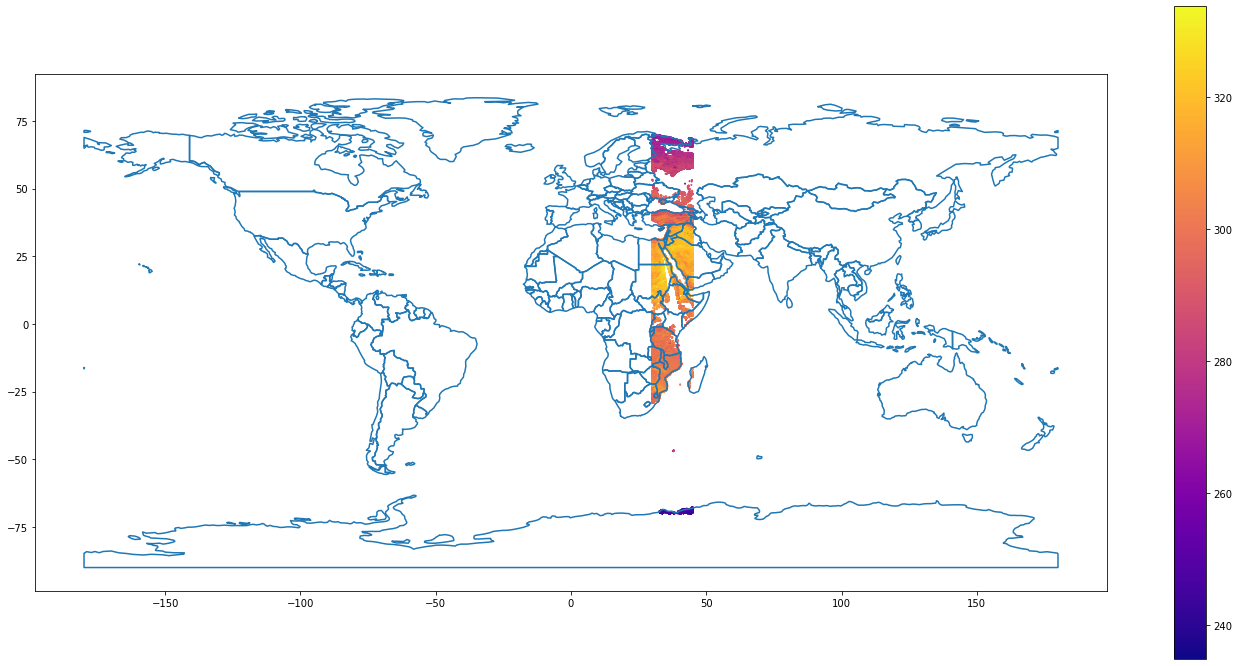

ERA land:


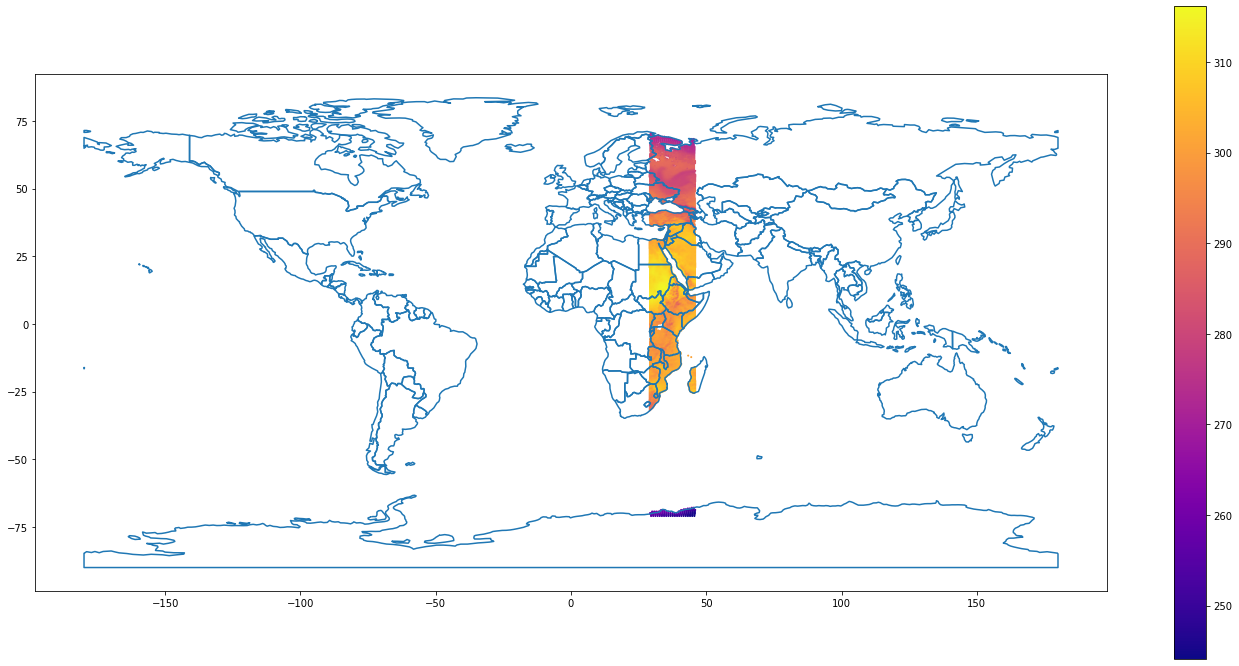

Matched, temperature:


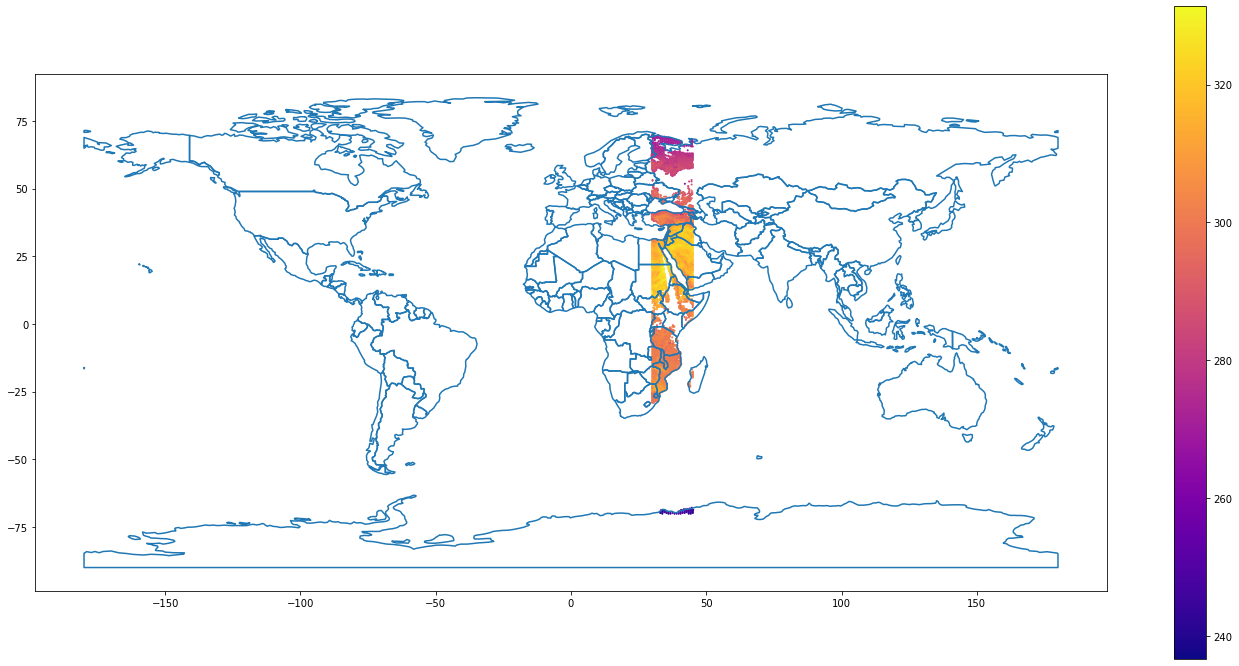

Matched, distance:


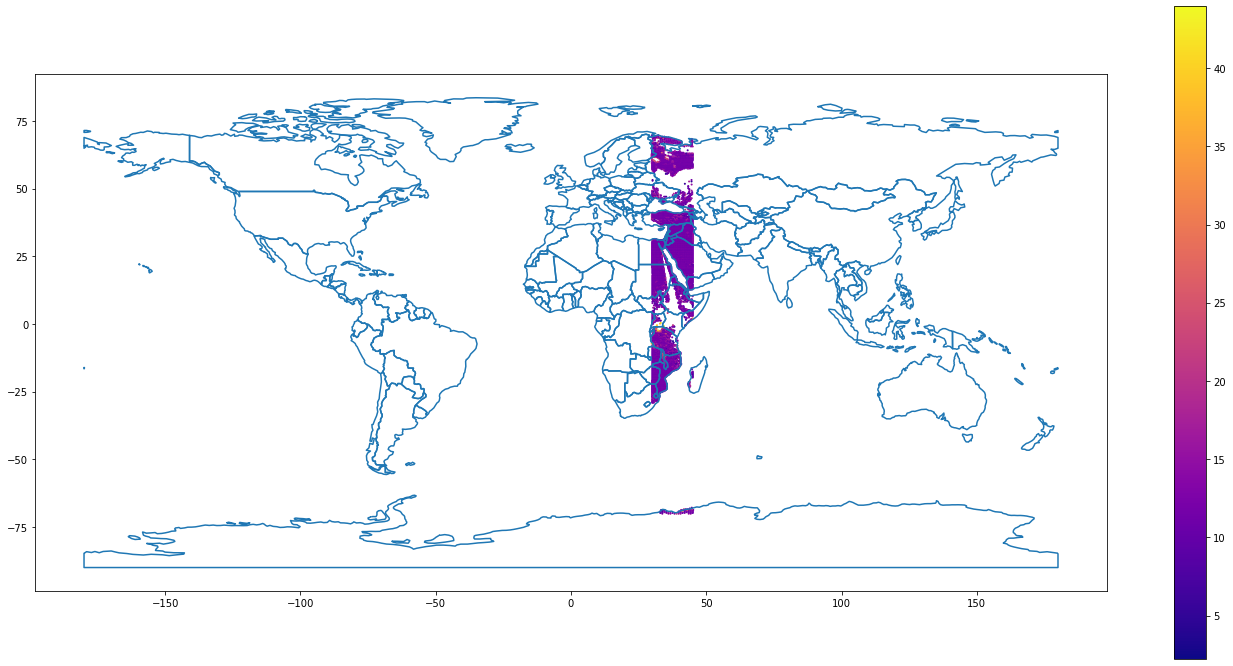

In [149]:
print('MODIS:')
plot_map(MODIS_df,'longitude','latitude','MODIS_LST')
print('ERA land:')
plot_map(ERA_df_land,'longitude','latitude','t2m')
print('Matched, temperature:')
plot_map(df,'longitude_ERA','latitude_ERA','MODIS_LST')
print('Matched, distance:')
plot_map(df,'longitude_ERA','latitude_ERA','H_distance')

# Time tests


In [2]:
def pipeline(date,utc_hour,satellite,latitude_bound,ERA_fields):

    # MODIS data
    MODIS = get_satellite_slice(date,utc_hour,satellite,latitude_bound)
    
    if not isinstance(MODIS,xr.DataArray):
        return pd.DataFrame() #If there is no appropriate data it just returns a 0. We then create an empty pd df so no matches will be found
    
    #Make MODIS ds a df
    MODIS_df = MODIS.to_dataframe(name='MODIS_LST').reset_index()
    
    #ERA data
    delta = 1.0 #Enveloping box.
    bounds = {"latitude_min" :MODIS.latitude.data.min()-delta,
          "latitude_max" :MODIS.latitude.data.max()+delta,
          "longitude_min":MODIS.longitude.data.min()-delta,
          "longitude_max":MODIS.longitude.data.max()+delta
          }
    
    ERA_sfc = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_sfc')
    ERA_skin = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_skin')
    ERA = xr.merge([ERA_sfc, ERA_skin])
    
    ERA_df_land = filter_out_sea(ERA) #just the land values
    

    #Explicitly deallocate everything
    MODIS.close()
    MODIS = None
    ERA_sfc.close()
    ERA_skin.close()
    ERA_sfc = None
    ERA_skin = None
    
    
    #Combine
    df_sk = faiss_knn(ERA_df_land,MODIS_df.dropna())
    
    return df_sk       
        

In [43]:

from datetime import timedelta, date

In [167]:
%%time

#Parameters
start_date = date(2018, 1, 2)
end_date   = date(2018, 1, 2)
dates = daterange(start_date,end_date)
hours = np.arange(0,24)


satellite='aquaDay'
latitude_bound=70
ERA_fields = None 



#Path for where to ouput saved files
IO_path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data/'


for dt in dates:
    d = dt.strftime("%Y-%m-%d")
    for h in hours:
        fname = satellite + '_'+str(d)+'_'+str(h)+'H_'+str(latitude_bound)+'L_+T.pkl'
        print(fname)
        df = pipeline(d,h,satellite,latitude_bound,ERA_fields)
        #df.to_pickle(IO_path+fname)



aquaDay_2018-01-02_0H_70L_+T.pkl
2018-01-01
aquaDay_2018-01-02_1H_70L_+T.pkl
2018-01-01
aquaDay_2018-01-02_2H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_3H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_4H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_5H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_6H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_7H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_8H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_9H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_10H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_11H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_12H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_13H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_14H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_15H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_16H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_17H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_18H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_19H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_20H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_21H_70L_+T.pkl
2018-01-02
aquaDay_2018-01-02_2

---

# Appendix

We could also use an Euclidean norm:

In [ ]:
ERA_df_land['latitude_rad'] = np.deg2rad(ERA_df_land['latitude'])
ERA_df_land['longitude_rad'] = np.deg2rad(ERA_df_land['longitude'])

ERA_df_land['coordinate_x'] = np.cos(ERA_df_land['latitude_rad']) * np.cos(ERA_df_land['longitude_rad'])
ERA_df_land['coordinate_y'] = np.cos(ERA_df_land['latitude_rad']) * np.sin(ERA_df_land['longitude_rad'])
ERA_df_land['coordinate_z'] = np.sin(ERA_df_land['latitude_rad'])

In [46]:
%%time









def pipelineV2(date,utc_hour,satellite,latitude_bound,ERA_fields):

        # MODIS data
    MODIS = get_satellite_slice(date,utc_hour,satellite,latitude_bound)
    
    if not isinstance(MODIS,xr.DataArray):
        return pd.DataFrame() #If there is no appropriate data it just returns a 0. We then create an empty pd df so no matches will be found
    
    #Make MODIS ds a df
    MODIS_df = MODIS.to_dataframe(name='MODIS_LST').reset_index()
    
    print('MODIS')
    #ERA data
    delta = 1.0 #Enveloping box.
    bounds = {"latitude_min" :MODIS.latitude.data.min()-delta,
          "latitude_max" :MODIS.latitude.data.max()+delta,
          "longitude_min":MODIS.longitude.data.min()-delta,
          "longitude_max":MODIS.longitude.data.max()+delta
          }
    
    ERA_sfc = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_sfc')
    ERA_skin = get_era_data(date, utc_hour, field=ERA_fields,bounds=bounds,source='ERA_skin')
    ERA = xr.merge([ERA_sfc, ERA_skin])
    
 
    ERA_df_land = filter_out_sea(ERA) 
    
    #Check we still have data in ERA_df_land
    #Edge case (e.g. 2020-09-02-23H) where the MODIS values are just of some islands in the middle of the pacific
    if ERA_df_land.empty:
        return pd.DataFrame()



    #Explicitly deallocate everything
    MODIS.close()
    MODIS = None
    ERA_sfc.close()
    ERA_skin.close()
    ERA_sfc = None
    ERA_skin = None
    
    
    display(ERA_df_land)
    display(MODIS_df.dropna())
    
    #Combine
    df_sk = faiss_knn(ERA_df_land,MODIS_df.dropna())
    
    return df_sk       
        











#Parameters
start_date = date(2020, 9, 2)
end_date   = date(2020, 9, 3)
dates = daterange(start_date,end_date)
hours = np.arange(0,24)

hours = [23]
satellite='aquaDay'
latitude_bound=70
ERA_fields = None 



#Path for where to ouput saved files
IO_path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/joined_ML_data/'


for dt in dates:
    d = dt.strftime("%Y-%m-%d")
    for h in hours:
        fname = satellite + '_'+str(d)+'_'+str(h)+'H_'+str(latitude_bound)+'L_+T.pkl'
        print(fname)
        df = pipelineV2(d,h,satellite,latitude_bound,ERA_fields)
        #df.to_pickle(IO_path+fname)




aquaDay_2020-09-02_23H_70L_+T.pkl
2020-09-02
MODIS
aquaDay_2020-09-03_23H_70L_+T.pkl
2020-09-03
MODIS


,values,sp,msl,u10,v10,t2m,latitude,longitude,number,time,...,sdfor,z,sd,sdor,isor,anor,slor,d2m,lsm,fal
21,21,101214.195312,101329.75,-3.337891,-1.591797,277.564270,70.398077,-150.400000,0,2020-09-03 23:00:00,...,2.348328,90.734131,0.0,5.200195,0.572842,-0.904022,0.000515,276.593628,0.790353,0.083994
22,22,101153.195312,101320.25,-3.247070,-1.496094,277.804504,70.398077,-149.600000,0,2020-09-03 23:00:00,...,2.469299,130.761475,0.0,4.751465,0.465922,-1.368578,0.000644,276.954956,0.926326,0.102686
23,23,101293.195312,101316.25,-3.145508,-1.376953,277.558411,70.398077,-148.800000,0,2020-09-03 23:00:00,...,1.827515,18.417725,0.0,3.384277,0.945770,-0.641987,0.000359,277.019409,0.594826,0.064463
42,42,100806.195312,101311.75,-1.717773,-1.034180,277.736145,70.117048,-150.750000,0,2020-09-03 23:00:00,...,8.226135,397.663818,0.0,12.397583,0.356477,-0.225723,0.002407,276.794800,0.975622,0.128290
43,43,100604.195312,101303.00,-1.536133,-1.166992,277.911926,70.117048,-150.000000,0,2020-09-03 23:00:00,...,7.773560,550.941162,0.0,16.676392,0.544692,-0.912081,0.002057,277.060425,0.999214,0.155909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,1355,99420.195312,101913.00,1.692383,2.205078,286.195129,57.189668,-135.500000,0,2020-09-03 23:00:00,...,115.907288,2028.761475,0.0,125.908203,0.696871,0.109598,0.021876,283.261597,0.644506,0.066492
1356,1356,96530.195312,101914.75,0.979492,1.119141,285.159973,57.189668,-135.000000,0,2020-09-03 23:00:00,...,178.061951,4442.453125,0.0,232.215942,0.463726,0.552821,0.036302,281.421753,0.816595,0.085581
1357,1357,99556.195312,101910.50,-0.341797,1.580078,286.497864,57.189668,-134.500000,0,2020-09-03 23:00:00,...,134.765198,1915.679443,0.0,161.737549,0.575869,-0.175267,0.026796,283.132690,0.634941,0.062342
1389,1389,96768.195312,101945.75,1.302734,1.107422,284.812317,56.908638,-135.000000,0,2020-09-03 23:00:00,...,190.276062,4263.109375,0.0,200.468140,0.629830,0.381066,0.033813,282.798706,0.924578,0.105265


,latitude,longitude,band,spatial_ref,MODIS_LST
326,-9.783333,-139.116667,1,0,302.447144
330,-9.783333,-138.983333,1,0,296.363647
776,-9.750000,-139.116667,1,0,305.106659
777,-9.750000,-139.083333,1,0,300.894531
1228,-9.716667,-139.050000,1,0,297.908875
...,...,...,...,...,...
156234,69.950000,-147.183333,1,0,276.866882
156260,69.950000,-146.316667,1,0,278.564453
156261,69.950000,-146.283333,1,0,278.196014
156262,69.950000,-146.250000,1,0,278.176239


CPU times: user 1.54 s, sys: 380 ms, total: 1.92 s
Wall time: 2.72 s
